In [1]:
import os
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore') #, category=RuntimeWarning) # , category=FutureWarning)


from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib

import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask
import dask.array as da

import itertools

from collections import OrderedDict

import inout as io
import gridop as gop
import diags as dg
import plot as cplt
from model import Model
from tools import wait_cluster_ready

### Launch dask cluster

In [2]:
from dask.distributed import Client, LocalCluster

# number of cores per node
workers_per_job = 4
# number of nodes
jobs = 2
nworkers = workers_per_job * jobs

# type of cluster
config = 1

if config==1:
    # pour 1 seul noeud
    cluster = LocalCluster(n_workers=2, threads_per_worker=2)
    client = Client(cluster)
else:
    # pour plusieurs noeuds:
    # ** processes and cores may be adjusted in order to have more memory 
    # or inversely more computational ressource
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=workers_per_job, cores=workers_per_job, walltime='02:00:00')
    w = cluster.scale(jobs=jobs)
    #cluster.adapt(minimum=1, maximum=5)

    client = Client(cluster)
    wait_cluster_ready(cluster, nworkers)
    
# put tmp files of dask in the scratch directory
try:
    scratch = os.environ['SCRATCH']
except:
    scratch = os.environ['HOME']
dask.config.set(local_directory=scratch)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 110.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39140,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 110.00 GiB
Comm: tcp://127.0.0.1:48287,Total threads: 2
Dashboard: http://127.0.0.1:58233/status,Memory: 55.00 GiB
Nanny: tcp://127.0.0.1:58708,


---
### Parameters

In [3]:
# Mozambic Initialization croco_xios template
# path = "/home/datawork-lops-osi/slgentil/data/moz/"
# filenames = [path+"moz_his.nc"]
# gridname = path+"moz_his.nc"
# longitude = 39.
# latitude = -21.
# depth = -100.
# seldate = '2000-01-13'
# model = "croco_xios"

# Benguela Initialization croco_native template
path = "/home/datawork-croco/public/ftp/CONFIGS_EXAMPLES/OLD_notuptodatev1.3_toberemoved/Run_BENGUELA_LR_inter_all/CROCO_FILES/"
filenames = [path+"croco_his.nc"]
gridname = path+"croco_his.nc"
longitude = 14.
latitude = -32.
depth = -100.
seldate = 2592000
model = "croco_native"

--- 
### Create an instance of the Model class 
which contains all the substitutions of the variables names depending on the model: 
- croco_xios

In [4]:
croco = Model(model)

### Open all the data files and the grid file and return a dataset. Create the xgcm grid.

In [5]:
%%time
drop_variables = [] 
ds, xgrid = io.open_files(croco, gridname, filenames, grid_metrics=1, 
                          drop_variables=drop_variables,
                          chunks={'t':1},
                          # chunks={'t':1, 's':1, 's_w':1},
                         )

CPU times: user 276 ms, sys: 32 ms, total: 308 ms
Wall time: 1.65 s


In [6]:
ds

<xarray.Dataset>
Dimensions:           (t: 11, x: 41, x_u: 42, y: 42, y_v: 43, s: 32, s_w: 33,
                       auxil: 4)
Coordinates: (12/15)
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39 40
  * x_u               (x_u) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * y                 (y) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40 41
  * y_v               (y_v) int64 0 1 2 3 4 5 6 7 8 ... 35 36 37 38 39 40 41 42
  * s                 (s) float32 -0.9844 -0.9531 -0.9219 ... -0.04688 -0.01562
  * s_w               (s_w) float32 -1.0 -0.9688 -0.9375 ... -0.03125 0.0
    ...                ...
    lat_u             (y, x_u) float32 dask.array<chunksize=(42, 42), meta=np.ndarray>
    lon_v             (y_v, x) float32 dask.array<chunksize=(43, 41), meta=np.ndarray>
    lat_v             (y_v, x) float32 dask.array<chunksize=(43, 41), meta=np.ndarray>
  * t                 (t) float64 0.0 2.592e+05 ... 2.333e+06 2.592e+06
    lon_p             (y_v, x_u) float32 dask.array<chunksize=(43, 42), meta=np.ndarray>
    lat_p             (y_v, x_u) float32 dask.array<chunksize=(43, 42), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/43)
    spherical         (t) |S1 dask.array<chunksize=(1,), meta=np.ndarray>
    xl                (t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    el                (t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Vtransform        (t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sc_r              (t, s) float32 dask.array<chunksize=(1, 32), meta=np.ndarray>
    sc_w              (t, s_w) float32 dask.array<chunksize=(1, 33), meta=np.ndarray>
    ...                ...
    sh_sfc_down       (t, y, x) float32 dask.array<chunksize=(1, 42, 41), meta=np.ndarray>
    rho0              float32 1.025e+03
    dx                (y, x) float32 dask.array<chunksize=(42, 41), meta=np.ndarray>
    dy                (y, x) float32 dask.array<chunksize=(42, 41), meta=np.ndarray>
    dx_u              (y, x_u) float32 dask.array<chunksize=(42, 42), meta=np.ndarray>
    dy_v              (y_v, x) float32 dask.array<chunksize=(43, 41), meta=np.ndarray>
Attributes: (12/54)
    type:          ROMS history file
    title:         BENGUELA TEST MODEL
    date:          
    rst_file:      CROCO_FILES/croco_rst.nc
    his_file:      CROCO_FILES/croco_his.nc
    avg_file:      CROCO_FILES/croco_avg.nc
    ...            ...
    x_sponge:      0.0
    v_sponge:      0.0
    sponge_expl:   Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   REGIONAL BENGUELA_LR MPI OBC_EAST OBC_WEST OBC_NORTH OBC_S...
    vtransform:    NEW

In [7]:
%%time
ds1 = ds.sel(t=seldate, method='nearest')
grid = gop.fast_xgcm_grid(ds1)
ds1

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 13.4 ms


<xarray.Dataset>
Dimensions:           (x: 41, x_u: 42, y: 42, y_v: 43, s: 32, s_w: 33, auxil: 4)
Coordinates: (12/15)
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39 40
  * x_u               (x_u) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * y                 (y) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40 41
  * y_v               (y_v) int64 0 1 2 3 4 5 6 7 8 ... 35 36 37 38 39 40 41 42
  * s                 (s) float32 -0.9844 -0.9531 -0.9219 ... -0.04688 -0.01562
  * s_w               (s_w) float32 -1.0 -0.9688 -0.9375 ... -0.03125 0.0
    ...                ...
    lat_u             (y, x_u) float32 dask.array<chunksize=(42, 42), meta=np.ndarray>
    lon_v             (y_v, x) float32 dask.array<chunksize=(43, 41), meta=np.ndarray>
    lat_v             (y_v, x) float32 dask.array<chunksize=(43, 41), meta=np.ndarray>
    t                 float64 2.592e+06
    lon_p             (y_v, x_u) float32 dask.array<chunksize=(43, 42), meta=np.ndarray>
    lat_p             (y_v, x_u) float32 dask.array<chunksize=(43, 42), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/43)
    spherical         |S1 dask.array<chunksize=(), meta=np.ndarray>
    xl                float32 dask.array<chunksize=(), meta=np.ndarray>
    el                float32 dask.array<chunksize=(), meta=np.ndarray>
    Vtransform        float32 dask.array<chunksize=(), meta=np.ndarray>
    sc_r              (s) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    sc_w              (s_w) float32 dask.array<chunksize=(33,), meta=np.ndarray>
    ...                ...
    sh_sfc_down       (y, x) float32 dask.array<chunksize=(42, 41), meta=np.ndarray>
    rho0              float32 1.025e+03
    dx                (y, x) float32 dask.array<chunksize=(42, 41), meta=np.ndarray>
    dy                (y, x) float32 dask.array<chunksize=(42, 41), meta=np.ndarray>
    dx_u              (y, x_u) float32 dask.array<chunksize=(42, 42), meta=np.ndarray>
    dy_v              (y_v, x) float32 dask.array<chunksize=(43, 41), meta=np.ndarray>
Attributes: (12/54)
    type:          ROMS history file
    title:         BENGUELA TEST MODEL
    date:          
    rst_file:      CROCO_FILES/croco_rst.nc
    his_file:      CROCO_FILES/croco_his.nc
    avg_file:      CROCO_FILES/croco_avg.nc
    ...            ...
    x_sponge:      0.0
    v_sponge:      0.0
    sponge_expl:   Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   REGIONAL BENGUELA_LR MPI OBC_EAST OBC_WEST OBC_NORTH OBC_S...
    vtransform:    NEW

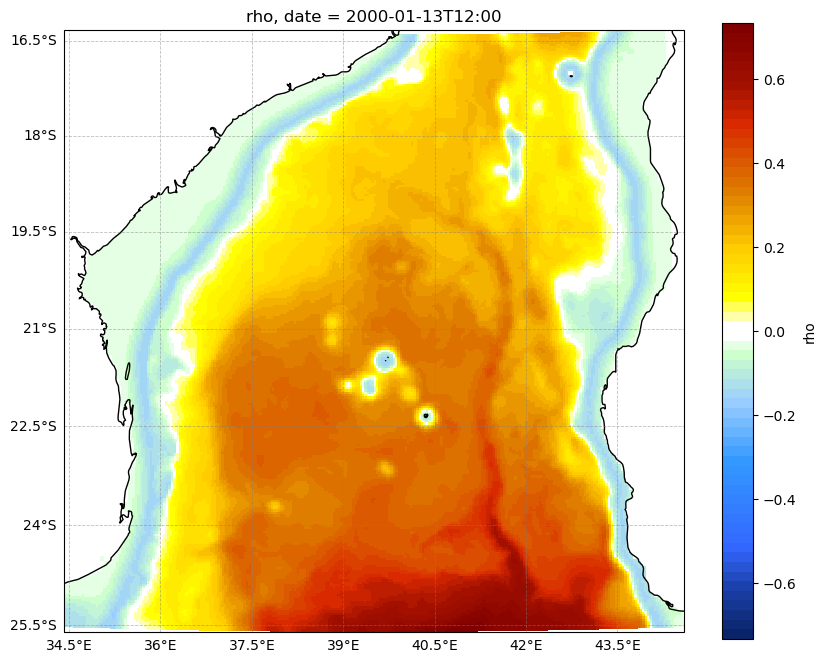

In [66]:
def density(temp, salt, z, rho0=1025, split=True):
    """Calculate the density [kg/m^3] as calculated in CROCO.

    Args
    - temp: (DataArray) tempemperature [Celsius]
    - salt: (DataArray) Salinity
    - z: (DataArray) Depth [m]. 
    - rho0: (float, optional, default=1025) reference density
    - split: (Boolean, optional, default=True) Activate EOS splitting of seawater compressibility effect
    
    Return
    -------
    - DataArray  of calculated density on rho/rho grids. Output is `[temp,Z,Y,X]`.

    Notes
    -----
    Equation of state based on CROCO Nonlinear/rho_eos.F

    Examples
    --------
    >>> density(temp, salt, z)
    """
    
    r00=999.842594
    r01=6.793952E-2
    r02=-9.095290E-3
    r03=1.001685E-4
    r04=-1.120083E-6
    r05=6.536332E-9
    r10=0.824493
    r11=-4.08990E-3
    r12=7.64380E-5
    r13=-8.24670E-7
    r14=5.38750E-9
    rS0=-5.72466E-3
    rS1=1.02270E-4
    rS2=-1.65460E-6
    r20=4.8314E-4
    K00=19092.56
    K01=209.8925
    K02=-3.041638
    K03=-1.852732e-3
    K04=-1.361629e-5
    K10=104.4077
    K11=-6.500517
    K12=0.1553190
    K13=2.326469e-4
    KS0=-5.587545
    KS1=+0.7390729
    KS2=-1.909078e-2
    B00=0.4721788
    B01=0.01028859
    B02=-2.512549e-4
    B03=-5.939910e-7
    B10=-0.01571896
    B11=-2.598241e-4
    B12=7.267926e-6
    BS1=2.042967e-3
    E00=+1.045941e-5
    E01=-5.782165e-10
    E02=+1.296821e-7
    E10=-2.595994e-7
    E11=-1.248266e-9
    E12=-3.508914e-9
    
    g = 9.81
    Tref=3.8
    Sref=34.5
    qp2=1.72e-05 
    
    def _K0(temp,salt):
        return (temp*( K01+temp*( K02+temp*( K03+temp*K04 ))) + 
                salt*( K10+temp*( K11+temp*( K12+temp*K13 )) + 
                      np.sqrt(salt)*( KS0+temp*( KS1+temp*KS2 ))) )

    def _K1(temp,salt):
        return  B00+temp*(B01+temp*(B02+temp*B03)) +salt*( B10+temp*( B11 + temp*B12 )+np.sqrt(salt)*BS1 )

    def _K2( temp,salt):
        return  E00+temp*(E01+temp*E02) +salt*(E10+temp*(E11+temp*E12))

    def _K( temp,salt,z):
        return K00 + _K0(temp,salt) + _K1(temp,salt) * z + _K2(temp,salt) * z**2

    def _qp1(T, S, Tref, Sref):
        # return 0.1*(rho0+_rho1(T,S))* (1/(K00 + _K0(T,S)) - 1/(K00 + _K0(Tref,Sref)))
        return ( 0.1*(rho0 + _rho1(T,S)) * (_K0(Tref,Sref) - _K0(T,S))
                /((K00 + _K0(T,S)) * (K00 + _K0(Tref,Sref)))
               )

    def _rho1(temp,salt):
        return  (r00-rho0 + temp*( r01+temp*( r02+ temp*( r03+ temp*( r04+ temp*r05 ))))+
                 salt*( r10+ temp*( r11+ temp*( r12+ temp*(r13+temp*r14 )))+
                       np.sqrt(salt)*(rS0+ temp*(rS1+ temp*rS2 ))+ salt*r20 ))
    
    if split:
        rho = _rho1(temp,salt) + _qp1(temp, salt, Tref, Sref) * z *(1. - qp2 * z)   
    else:
        rho = (_rho1(temp,salt) ) / (1 - 0.1 * z / _K(temp,salt,z))
        
    return rho.rename("rho")

ds1 = ds.sel(t=seldate, method='nearest')
grid = gop.fast_xgcm_grid(ds1)
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r')
rho =dg.density(ds1.temp, ds1.salt, z)*ds1.mask

kwargs = {'vmin': -1.7, 'vmax': 1.7, 'extend':'both'}
diff = (ds1.rho - rho).rename("rho")
cplt.plotfig(diff.isel(s=0))


### U slice at a constant depth

CPU times: user 348 ms, sys: 24 ms, total: 372 ms
Wall time: 7.3 s


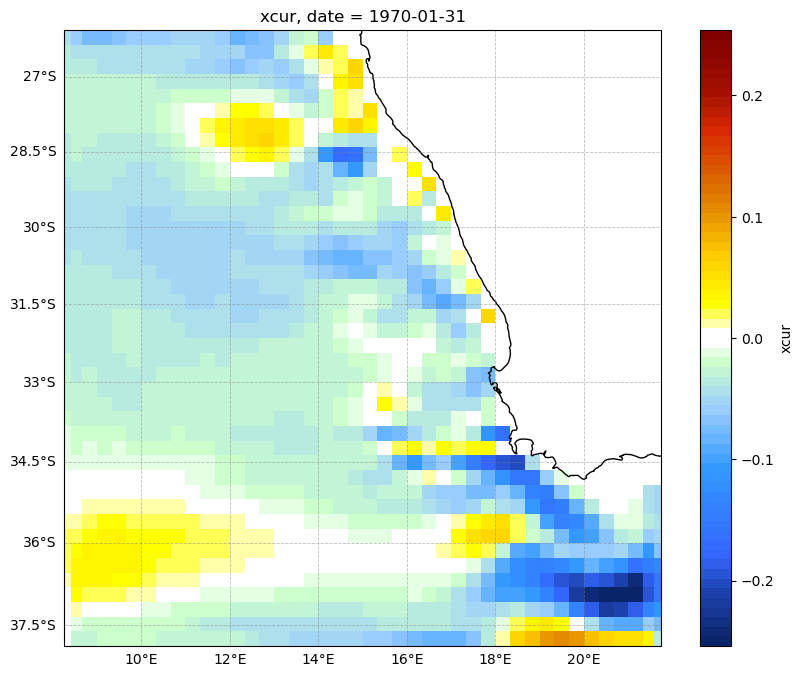

In [8]:
%%time
# depths at u points
z_u = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='u')
# slice of u at a constant depth
uslice= gop.slices(croco, ds1.xcur, z_u, ds=ds1, depth=depth)
# plot the slice of u
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(uslice) #, **kwargs)

### V slice at a constant depth

CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 249 ms


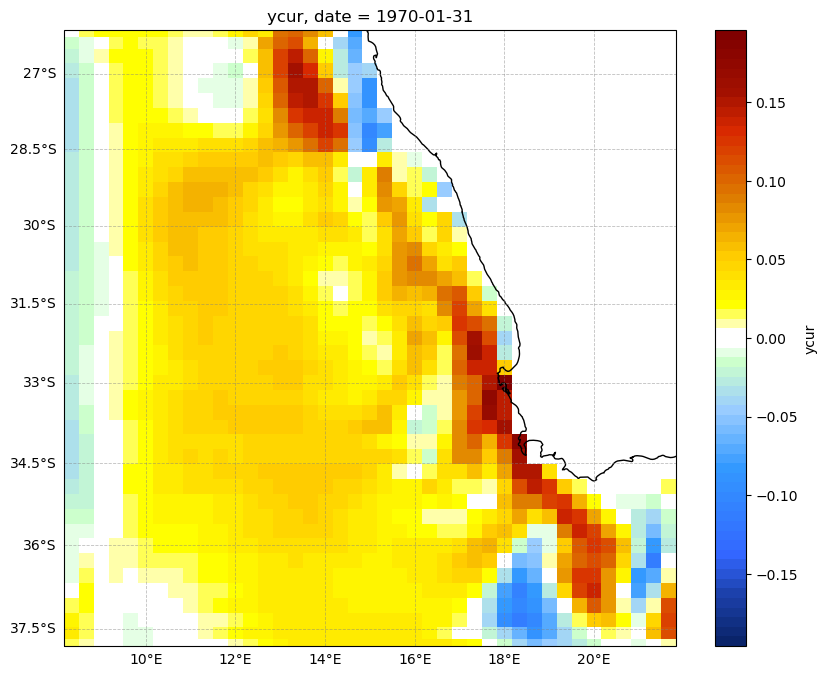

In [9]:
%%time
# depth at v points
z_v = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, hgrid='v')
# slice of v at a constant depth
vslice= gop.slices(croco, ds1.ycur, z_v, ds=ds1, depth=depth)
# plot the v slice
kwargs = {'vmin': -1.5, 'vmax': 1.5, 'extend':'both'}
cplt.plotfig(vslice) #, **kwargs)

### Rotate u,v to lat,lon coord

In [10]:
%%time
# depth at rho points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r')
aslice= ds1.angle
# compute u_EW and v_SN
[urot,vrot] = gop.rot_uv(uslice, vslice, aslice, grid)

CPU times: user 572 ms, sys: 32 ms, total: 604 ms
Wall time: 601 ms


### Compute relative vorticity

distributed.nanny - WARNING - Restarting worker


CPU times: user 284 ms, sys: 12 ms, total: 296 ms
Wall time: 615 ms


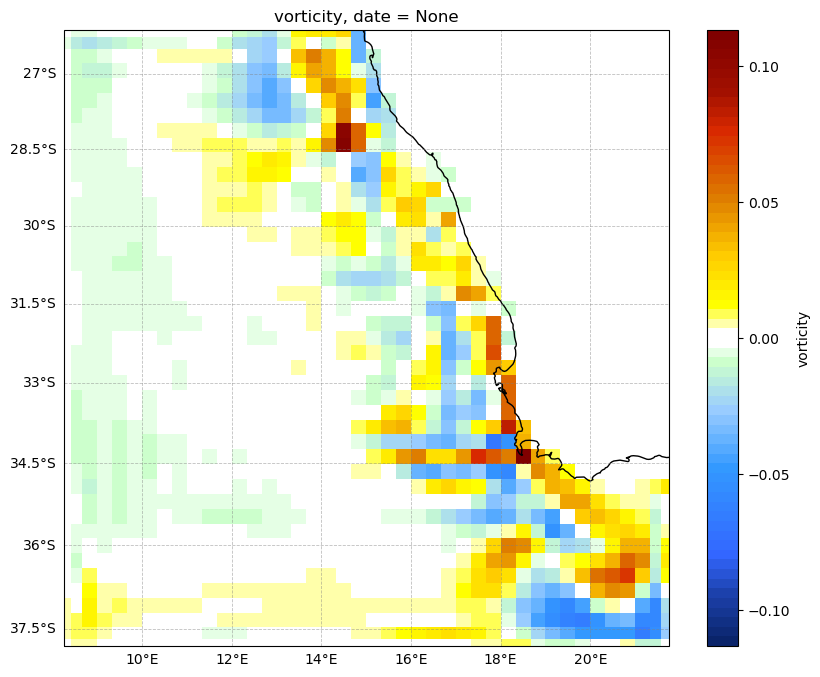

In [11]:
%%time
# compute the relative vorticity at a constant depth
relvort = dg.relative_vorticity_z(croco, ds=ds1, xgrid=grid, u=urot, v=vrot)
# plot the relative vorticity
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(relvort) #, **kwargs)

### Compute dtemp/dz on a longitudinal slice

/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 260 ms, sys: 32 ms, total: 292 ms
Wall time: 7.02 s


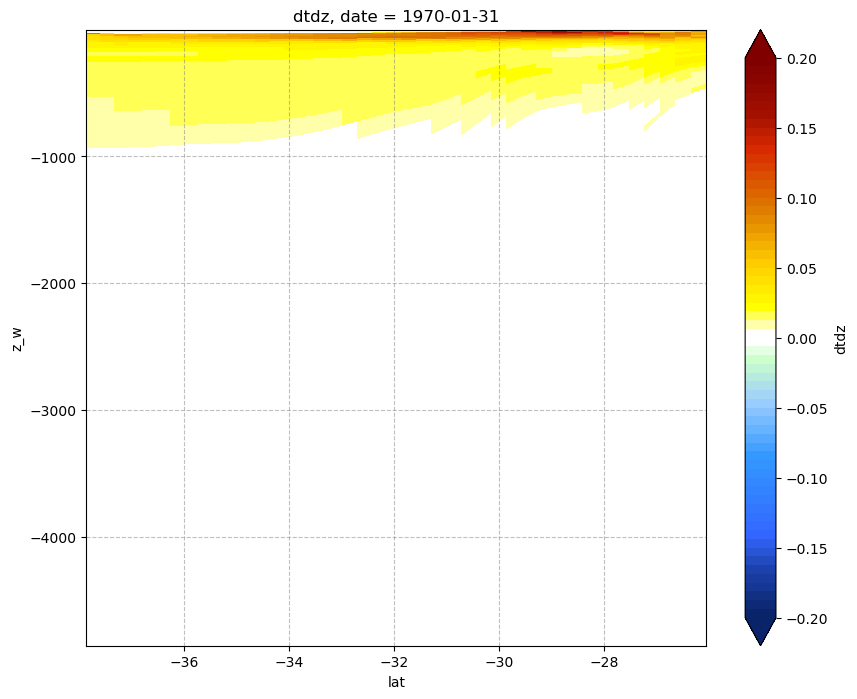

In [12]:
%%time
# longitudinal slice of temperature
tslice = gop.slices(croco, ds1.temp, z, ds=ds1, longitude=longitude)
# compute dtemp/dz
dtdz = dg.dtempdz(xgrid, tslice, tslice.z)
# plot dtemp/dz
kwargs = {'vmin': -0.2, 'vmax': 0.2, 'extend':'both'}
cplt.plotfig(dtdz, **kwargs)

### Compute Richardson on a longitudinal slice

/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 476 ms, sys: 100 ms, total: 576 ms
Wall time: 563 ms


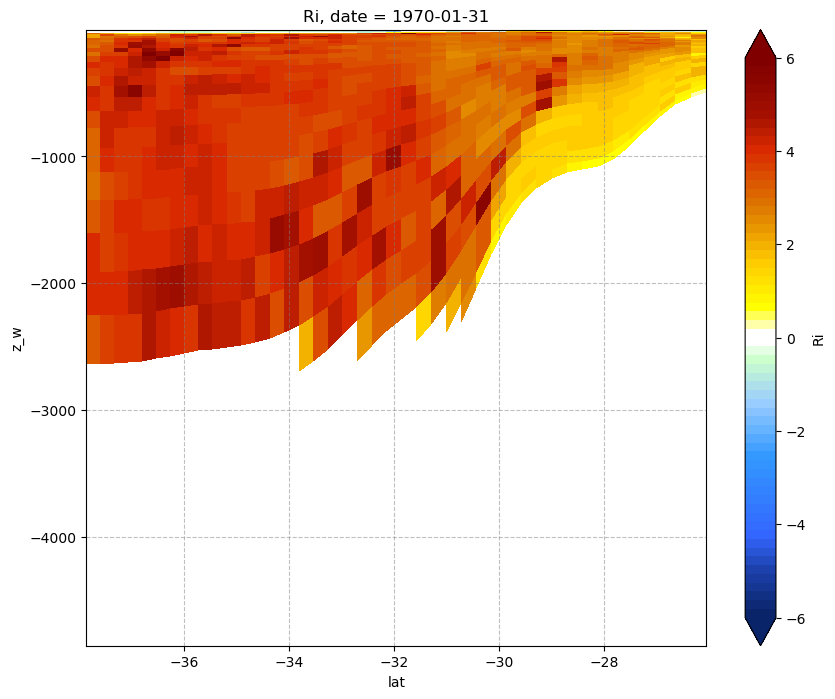

In [13]:
%%time
# longitudinal slices of rho,u,v
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
rho = dg.density(ds1.temp, ds1.salt, z=z)
rslice = gop.slices(croco, rho, z, ds=ds1, longitude=longitude)
uslice = gop.slices(croco, ds1.xcur, z_u, ds=ds1, longitude=longitude)
vslice = gop.slices(croco, ds1.ycur, z_v, ds=ds1, longitude=longitude)
# compute the Richardson number
Ri = dg.richardson(grid, uslice, vslice, rslice, rslice.z)
# plot the Richardson number
kwargs = {'vmin': -6., 'vmax': 6., 'extend':'both'}
cplt.plotfig(Ri, **kwargs)

### Compute the Pressure

CPU times: user 508 ms, sys: 108 ms, total: 616 ms
Wall time: 611 ms


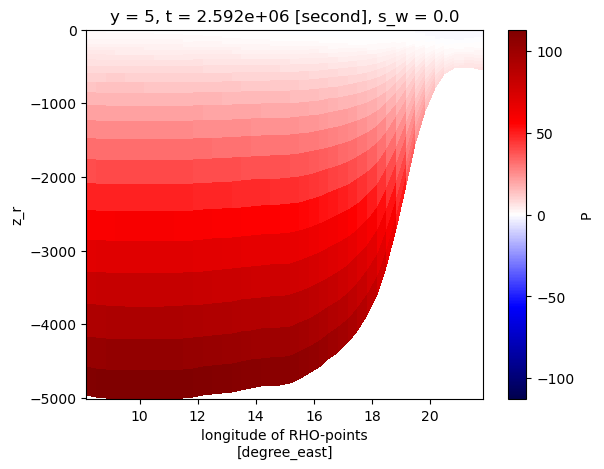

In [14]:
%%time
# depth at rho points and w points
z_r = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
z_w = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='w')
rho = dg.density(ds1.temp, ds1.salt, z=z)
# compute the pressure
P = dg.get_p(grid, rho, z_w, z_r)
# plot the pressure
coords = gop.get_spatial_coords(P)
P.isel(y=int(P.y.size/8)).plot(x=coords['lon'], y=coords['z'], cmap="seismic")

distributed.nanny - WARNING - Restarting worker
/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 748 ms, sys: 48 ms, total: 796 ms
Wall time: 7.68 s


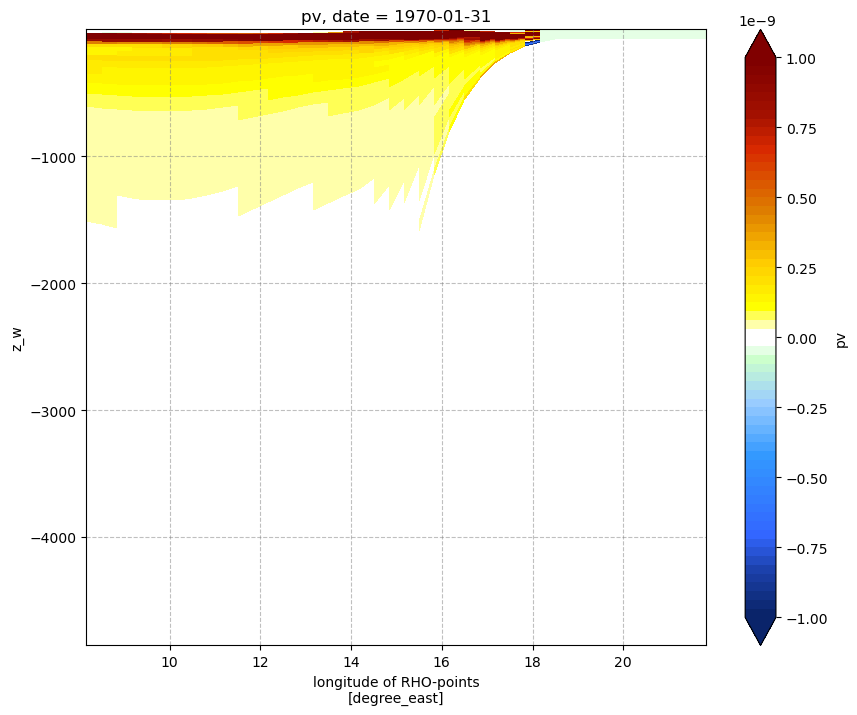

In [15]:
%%time
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
rho = dg.density(ds1.temp, ds1.salt, z=z)
pv = dg.ertel_pv(grid, ds1.xcur, ds1.ycur, ds1.zcur, rho, z, ds1.f)
kwargs = {'vmin': -1.e-9, 'vmax': 1.e-9, 'extend':'both'}
cplt.plotfig(pv.isel(y=int(ds1.y.size*0.5)), **kwargs)


In [16]:
# cluster.close()